# Semantic Segmentation

*General structure following [fast.ai notebook on camvid](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-camvid.ipynb)*

In [1]:
# No need to reload the notebook if any change in the fastai library
%reload_ext autoreload
%autoreload 2

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pathlib import Path
import PIL

from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from fastai.callbacks.tracker import SaveModelCallback

# Load Data

### We use the [Berkely Deep Drive Dataset](https://bdd-data.berkeley.edu/) which contains a rich labeled dataset for image segmentation in diverse conditions (weather, city, reference car…).

In [3]:
path_data = Path('/home/ruslan/Desktop/Berkeley_Segmentation/semantic-segmentation/data/bdd100k/seg')
path_lbl = path_data/'labels'
path_img = path_data/'images'

### Images and labels filenames

In [4]:
fnames = get_image_files(path_img, recurse = True)
fnames[:3]

[PosixPath('/home/ruslan/Desktop/Berkeley_Segmentation/semantic-segmentation/data/bdd100k/seg/images/val/830c6cb2-6b35fcf9.jpg'),
 PosixPath('/home/ruslan/Desktop/Berkeley_Segmentation/semantic-segmentation/data/bdd100k/seg/images/val/9a5d0ab3-00000000.jpg'),
 PosixPath('/home/ruslan/Desktop/Berkeley_Segmentation/semantic-segmentation/data/bdd100k/seg/images/val/7f1d11ea-fdf50000.jpg')]

In [5]:
lbl_names = get_image_files(path_lbl, recurse = True)
lbl_names[:3]

[PosixPath('/home/ruslan/Desktop/Berkeley_Segmentation/semantic-segmentation/data/bdd100k/seg/labels/val/a91b7555-00000390_train_id.png'),
 PosixPath('/home/ruslan/Desktop/Berkeley_Segmentation/semantic-segmentation/data/bdd100k/seg/labels/val/a70efb84-00000000_train_id.png'),
 PosixPath('/home/ruslan/Desktop/Berkeley_Segmentation/semantic-segmentation/data/bdd100k/seg/labels/val/96dd1db0-e186788a_train_id.png')]

### Take a look at the image data we have

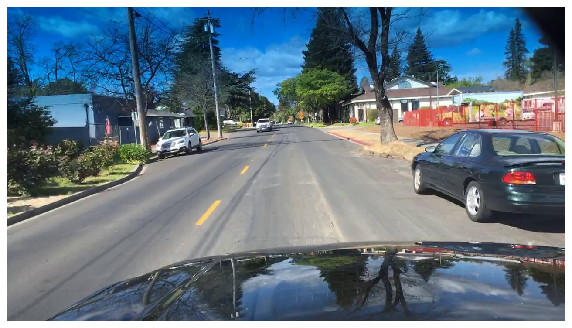

In [6]:
img_f = fnames[10]
img = open_image(img_f)
img.show(figsize=(10,10))

### Now we need to create a function that maps from the path of an image to the path of its segmentation.

In [7]:
get_y_fn = lambda x: path_lbl/x.parts[-2]/f'{x.stem}_train_id.png'

img_f, get_y_fn(img_f)

(PosixPath('/home/ruslan/Desktop/Berkeley_Segmentation/semantic-segmentation/data/bdd100k/seg/images/val/a7e76c3d-4ef7b669.jpg'),
 PosixPath('/home/ruslan/Desktop/Berkeley_Segmentation/semantic-segmentation/data/bdd100k/seg/labels/val/a7e76c3d-4ef7b669_train_id.png'))

### We can now use the obtained label path to open a segmentation image.

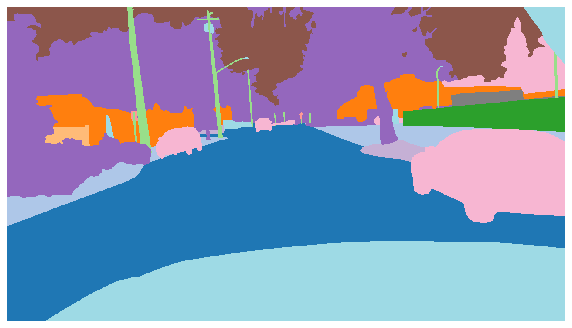

In [8]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(10,10), alpha=1)

In [9]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([ 720, 1280]), tensor([[[10, 10, 10,  ..., 19, 19, 19],
          [10, 10, 10,  ..., 19, 19, 19],
          [10, 10, 10,  ..., 19, 19, 19],
          ...,
          [ 0,  0,  0,  ..., 19, 19, 19],
          [ 0,  0,  0,  ..., 19, 19, 19],
          [ 0,  0,  0,  ..., 19, 19, 19]]]))

# Datasets

### Now that we know how our data looks like we can create our data-set using the SegmentationItemList class provided by FastAI.

In [10]:
size = (180, 320)
bs = 16

In [11]:
# Classes extracted from dataset source code
# -> https://github.com/ucbdrive/bdd-data/blob/master/bdd_data/label.py

segmentation_classes = [
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car',
    'truck', 'bus', 'train', 'motorcycle', 'bicycle', 'void'
]
void_code = 19  # used to define accuracy and disconsider unlabeled pixels

In [12]:
src = (SegmentationItemList.from_folder(path_img) # Load in x data from folder
       .split_by_folder(train='train', valid='val') # Split data into training and validation set 
       .label_from_func(get_y_fn, classes = segmentation_classes)) # Label data using the get_y_fn function

In [13]:
src

LabelLists;

Train: LabelList (7000 items)
x: SegmentationItemList
Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280)
y: SegmentationLabelList
ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280)
Path: /home/ruslan/Desktop/Berkeley_Segmentation/semantic-segmentation/data/bdd100k/seg/images;

Valid: LabelList (1000 items)
x: SegmentationItemList
Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280)
y: SegmentationLabelList
ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280)
Path: /home/ruslan/Desktop/Berkeley_Segmentation/semantic-segmentation/data/bdd100k/seg/images;

Test: None

In [14]:
src.train.y.loss_func

FlattenedLoss of CrossEntropyLoss()

### Perform data augmentation and create databunch

In [15]:
# Define transformations to apply 
import numpy as np

train_tfms = [
        brightness(change=(0.1, 0.9), p=0.5),
        rotate(degrees=(-20,20), p=0.5),
        contrast(scale=(0.5, 2.), p=0.5),
        jitter(magnitude=np.random.uniform(-0.05, 0.05), p=0.1),
        symmetric_warp(magnitude=(-0.2,0.2), p=0.5),
        zoom(scale=np.random.uniform(1,1.6), p=0.5)
]

valid_tfms = []
# valid_tfms = train_tfms

transformations = [train_tfms, valid_tfms]
# transformations = get_transforms()

data = (src.transform(transformations, size=size, tfm_y=True)
        .databunch(bs=bs) # Create a databunch
        .normalize(imagenet_stats)) # Normalize for resnet

### We can show a few examples using the show_batch method which is available for all sorts of databunches

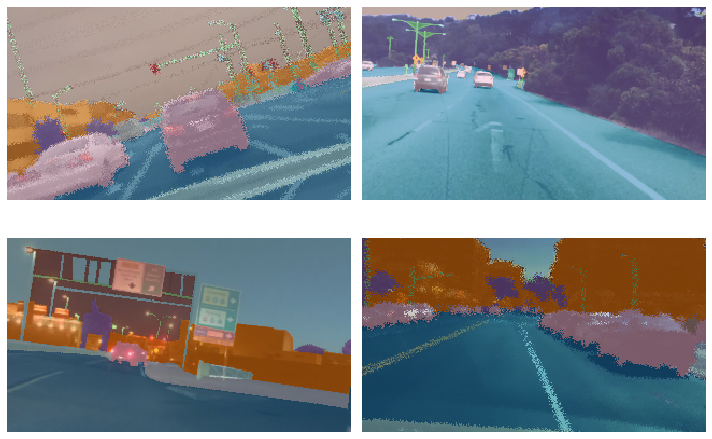

In [16]:
data.show_batch(2, figsize=(10,7))
# data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

It is also possible to create annotated segmenatation data from scratch by youe own, using such tools as:
https://github.com/abreheret/PixelAnnotationTool

## Model creation and training

A function that will measure the accuracy of the model. The accuracy in an image segmentation problem is the same as that in any classification problem.

Accuracy = no of correctly classified pixels / total pixels

However in this case, some pixels are labelled as Void and shouldn’t be considered when calculating the accuracy. Hence we make a new function for accuracy where we avoid those labels.

In [17]:
def acc(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def dice(input:Tensor, targs:Tensor, iou:bool=True, eps:float=1e-8)->Rank0Tensor:
    """
    Dice coefficient metric for binary target.
    If iou=True, returns iou metric, classic for segmentation problems.
    """
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input * targs).sum(dim=1).float()
    union = (input+targs).sum(dim=1).float()
    if not iou: l = 2. * intersect / union
    else: l = intersect / (union-intersect+eps)
    l[union == 0.] = 1.
    return l.mean()

In [18]:
metrics=[acc, dice]
wd=1e-5 # weight decay

To create a U-NET in FastAI the unet_learner class can be used. We not only going to pass it our data but we will also specify an encoder-network (Resnet34 in our case), our accuracy function as well as a weight-decay

In [19]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

With our model ready to go we can now search for a fitting learning rate and then start training our model

In [ ]:
lr_find(learn)
learn.recorder.plot()

To read about picking a learning rate, go to:
https://towardsdatascience.com/fastai-image-classification-32d626da20
We need to select a point on the graph with the fastest decrease in the loss.

In [20]:
lr=3e-3 # pick a learning rate

In [ ]:
learn.fit_one_cycle(10, slice(lr),
                    callbacks=[SaveModelCallback(learn, name='best_model', every='epoch', monitor='accuracy')])#, pct_start=0.9) # train model

Standardly only the decoder is unfrozen, which means that our pretrained encoder didn’t receive any training yet so we will now show some results and then train the whole model.

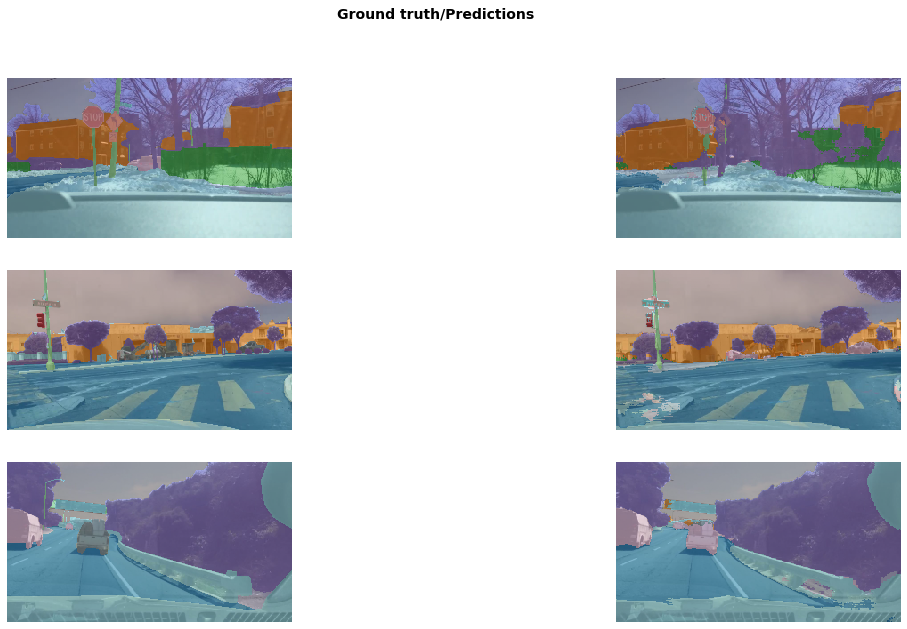

In [31]:
import os
current_path = os.getcwd()
learn.save(current_path + '/saved_models/berkeley-stage-1') # save model
# learn.save('berkeley-stage-1')
learn.show_results(rows=3, figsize=(20,10))

### Perform fine-tuning of all layers

In [ ]:
# find and plot lr again
lr_find(learn)
learn.recorder.plot()

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.unfreeze() # unfreeze all layers

In [ ]:
lrs = slice(6e-5, 8e-3)

In [ ]:
# train the model
learn.fit_one_cycle(2, lrs)

In [ ]:
learn.show_results(rows=3, figsize=(20,10))

In [ ]:
learn.save("/home/ruslan/Desktop/berkeley-stage-2", return_path=True)

In [ ]:
print(learn.summary())

## Model evaluation on test dataset

In [21]:
# Training and testing databunch creation
data_test = (SegmentationItemList.from_folder(path_img)
            .split_by_folder(train='train', valid='test')
            .label_from_func(get_y_fn, classes = segmentation_classes)
#             .transform(transformations)
            .databunch(bs=bs)
            .normalize(imagenet_stats))

# learn = unet_learner(data_test, models.resnet34, metrics=metrics, wd=wd)
learn.load('berkeley-stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (7000 items)
x: SegmentationItemList
Image (3, 180, 320),Image (3, 180, 320),Image (3, 180, 320),Image (3, 180, 320),Image (3, 180, 320)
y: SegmentationLabelList
ImageSegment (1, 180, 320),ImageSegment (1, 180, 320),ImageSegment (1, 180, 320),ImageSegment (1, 180, 320),ImageSegment (1, 180, 320)
Path: /home/ruslan/Desktop/Berkeley_Segmentation/semantic-segmentation/data/bdd100k/seg/images;

Valid: LabelList (1000 items)
x: SegmentationItemList
Image (3, 180, 320),Image (3, 180, 320),Image (3, 180, 320),Image (3, 180, 320),Image (3, 180, 320)
y: SegmentationLabelList
ImageSegment (1, 180, 320),ImageSegment (1, 180, 320),ImageSegment (1, 180, 320),ImageSegment (1, 180, 320),ImageSegment (1, 180, 320)
Path: /home/ruslan/Desktop/Berkeley_Segmentation/semantic-segmentation/data/bdd100k/seg/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 

In [25]:
preds,_ = learn.get_preds(ds_type=SegmentationItemList) 
labels = np.argmax(preds, 1)

In [30]:
labels[0]

tensor([[ 8,  8,  8,  ..., 19, 19, 19],
        [ 8,  8,  8,  ..., 19, 19, 19],
        [ 8,  8,  8,  ..., 19, 19, 19],
        ...,
        [19, 19, 19,  ..., 19, 19, 19],
        [19, 19, 19,  ..., 19, 19, 19],
        [19, 19, 19,  ..., 19, 19, 19]])

## Making predictions

In [22]:
# learn.load(current_path + '/saved_models/berkeley-stage-1')
learn.load('berkeley-stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (7000 items)
x: SegmentationItemList
Image (3, 180, 320),Image (3, 180, 320),Image (3, 180, 320),Image (3, 180, 320),Image (3, 180, 320)
y: SegmentationLabelList
ImageSegment (1, 180, 320),ImageSegment (1, 180, 320),ImageSegment (1, 180, 320),ImageSegment (1, 180, 320),ImageSegment (1, 180, 320)
Path: /home/ruslan/Desktop/Berkeley_Segmentation/semantic-segmentation/data/bdd100k/seg/images;

Valid: LabelList (1000 items)
x: SegmentationItemList
Image (3, 180, 320),Image (3, 180, 320),Image (3, 180, 320),Image (3, 180, 320),Image (3, 180, 320)
y: SegmentationLabelList
ImageSegment (1, 180, 320),ImageSegment (1, 180, 320),ImageSegment (1, 180, 320),ImageSegment (1, 180, 320),ImageSegment (1, 180, 320)
Path: /home/ruslan/Desktop/Berkeley_Segmentation/semantic-segmentation/data/bdd100k/seg/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 

Inference took 0.0270 [sec]
Original shape: torch.Size([3, 800, 1600])
Resized shape: torch.Size([3, 180, 320])


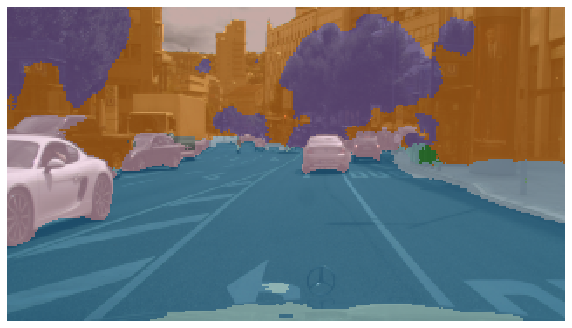

In [24]:
test_img = open_image('/home/ruslan/Desktop/example_images/example_04.png')

import time
start = time.time()
output = learn.predict( test_img )
print('Inference took %.4f [sec]'%(time.time()-start))

print('Original shape:', test_img.shape)
test_resized = test_img.apply_tfms(None, size=output[0].shape)
print('Resized shape:', test_resized.shape)

test_resized.show(figsize=(10,10), y=learn.predict(test_resized)[0])